In [15]:
import torch
import sys
import os
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F 
import torchvision.transforms as T
sys.path.append(os.path.join(os.getcwd(), 'src'))

from tqdm import tqdm 
import csv
import data_loader
import transformer
import model
from CycleGan import Generator, ResBlock
import functions

In [16]:
test_set = data_loader.MaskedDataset(img_dir=os.path.join(os.getcwd(), "data", "test_target_data", "target_test" ), mask_path=os.path.join(os.getcwd(), "data", "test_target_data", "target_annotations" ), mode=3)
test_loader = DataLoader(test_set)

Reading data into memory...


100%|██████████| 15/15 [00:00<00:00, 2060.41it/s]

Dataset initialized!


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cycleganG = torch.load("/u/09/huttuna6/unix/Documents/LST_GIT/lst-project/model/CycleGan_2022-05-12/LC_mb_e_background_noise_better_80_per_empty_G_B2A.pt",  map_location=device)

In [18]:
Unet = model.Unet(numChannels=1, classes=2, dropout = 0.1)
Unet.load_state_dict(torch.load("/u/09/huttuna6/unix/Documents/LST_GIT/lst-project/model/Unet_AugmentedLiveCell_20epochs_5batch_final_resize256.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [21]:
def final_evaluation(loader, Nets, name, mode=1):
    mask_list = []
    resize_64 = T.Resize((64,64))
    resize_256 = T.Resize((256,256))
    resize_orig = T.Resize((1544,2064))

    if mode == 1:
        net = Nets
        it = 0
        for image, mask in tqdm(loader):
            crops = transformer.slice_image(image,256)
            predictions = []
            pred_row = []
        
            with torch.no_grad():
                for i in range(len(crops)):
                    for j in range(len(crops[0])):
                        pred = net(resize_64.forward(crops[i][j]))
                        pred_row.append(resize_256.forward(pred))
                    predictions.append(pred_row)
                    pred_row = []
            new_mask = transformer.rebuild(predictions, (1544,2064))

            fig = plt.figure(figsize= 2 * np.array(plt.rcParams['figure.figsize']))
            plt.subplot(1,3,1)
            plt.imshow(image.squeeze(0).permute((1,2,0)), cmap = 'gray')
            plt.title("Original image")
            plt.subplot(1,3,2)
            plt.imshow(mask.permute((1,2,0)), cmap = 'gray')
            plt.title("True mask")
            plt.subplot(1,3,3)
            plt.imshow(new_mask.permute((1,2,0)), cmap = 'gray')
            plt.title("Predicted mask")
            fig.tight_layout()
            savepath = os.path.join(os.getcwd(),"model", "results", name, str(it) +".svg")
            plt.savefig(savepath, format="svg")
            it +=1

    if mode == 2:
        Unet, CG_G_B2A =Nets
        it = 0
        for image, mask in tqdm(loader):
            crops = transformer.slice_image(image,256)
            predictions = []
            pred_row = []
  
            with torch.no_grad():
                for i in range(len(crops)):
                    for j in range(len(crops[0])):
                        pred = CG_G_B2A(resize_64.forward(crops[i][j]))
                        pred_row.append(resize_256.forward(pred))
                    predictions.append(pred_row)
                    pred_row = []
            new_image = transformer.rebuild(predictions, (1544,2064))
            with torch.no_grad():
                maski = Unet(resize_256.forward(new_image))
                new_mask = (F.softmax(maski, dim=1)).float()
                new_mask = new_mask[0,1,:,:].unsqueeze(0).detach()
                prediction = resize_orig.forward(new_mask)
                mask_list.append((mask,prediction))
        
            fig = plt.figure(figsize= 2 * np.array(plt.rcParams['figure.figsize']))
            plt.subplot(1,4,1)
            plt.imshow(image.squeeze(0).permute((1,2,0)), cmap = 'gray')
            plt.title("Original image")
            plt.subplot(1,4,2)
            plt.imshow(new_image.squeeze(0).permute((1,2,0)), cmap = 'gray')
            plt.title("Shifted domain")
            plt.subplot(1,4,3)
            plt.imshow(mask.permute((1,2,0)), cmap = 'gray')
            plt.title("True mask")
            plt.subplot(1,4,4)
            plt.imshow(prediction.permute((1,2,0)), cmap = 'gray')
            plt.title("Predicted mask")
            fig.tight_layout()
            savepath = os.path.join(os.getcwd(),"model", "results", name, str(it) +".svg")
            plt.savefig(savepath, format="svg")
            it +=1

    scores = [name]
    for mask, prediction in tqdm(mask_list):
        score = 1- functions.dice_loss(mask.type(torch.FloatTensor), prediction.type(torch.FloatTensor))
        scores.append(score.item())
    scores.append((sum(scores[1:])/15))
    f = open(os.path.join(os.getcwd(),"model", "results", "scores.csv"), 'a')
    writer = csv.writer(f)
    writer.writerow(scores)
    f.close()
                        

100%|██████████| 15/15 [00:00<00:00, 234.02it/s]


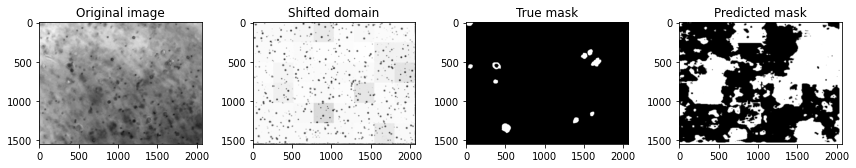

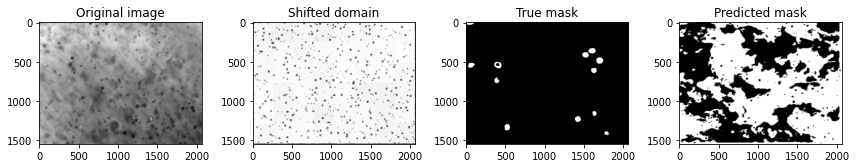

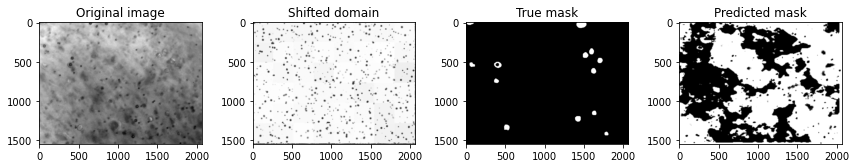

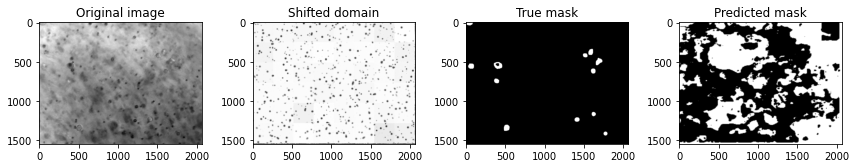

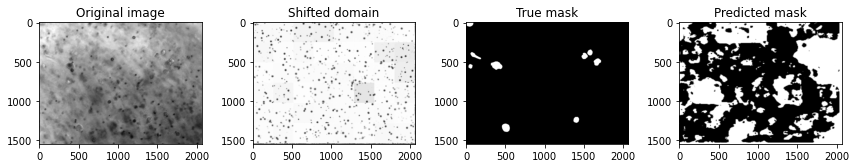

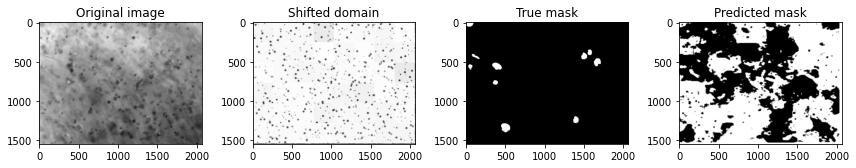

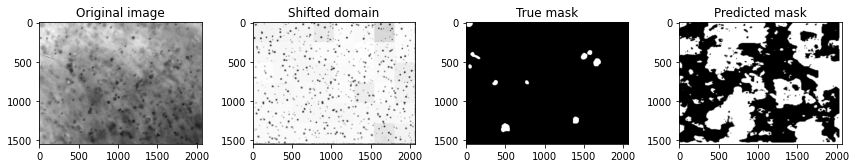

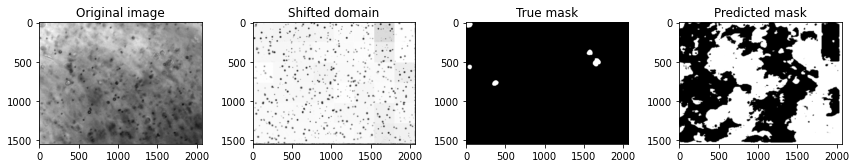

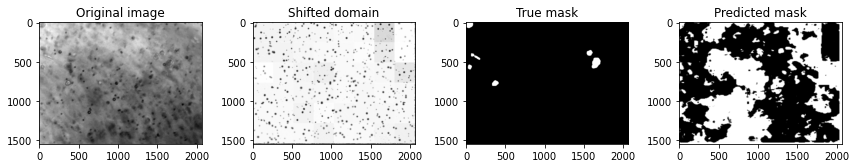

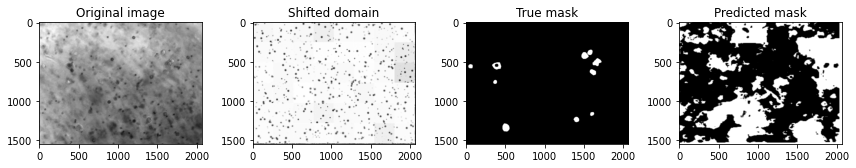

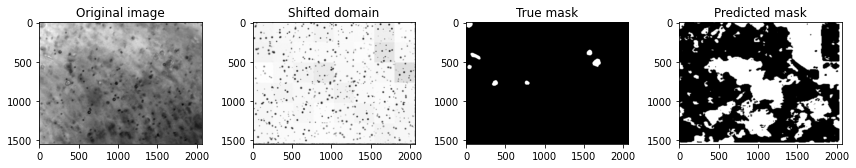

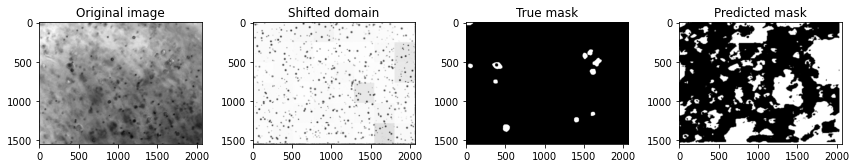

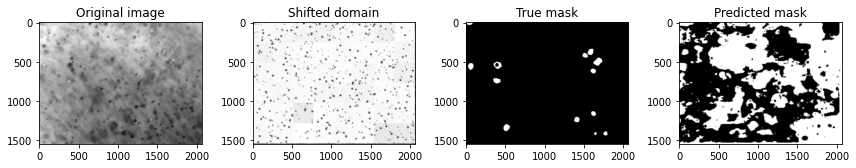

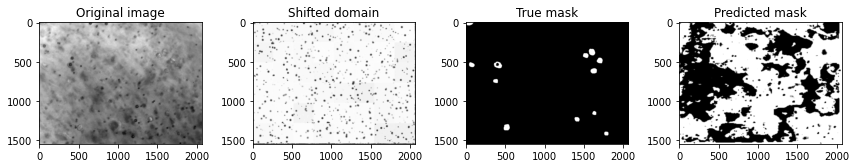

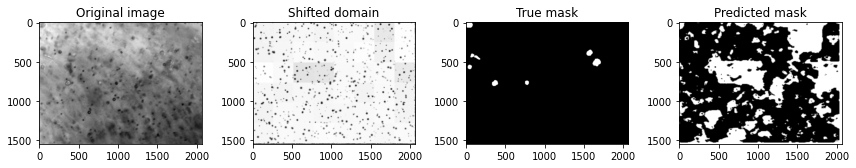

In [22]:
final_evaluation(test_loader, (Unet, cycleganG), "LC_mb_e_noise_100_epochs", mode=2)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_DIR = os.path.join(os.getcwd(), "model")
Unet_LC_mb_mix_path = os.path.join(MODEL_DIR, "Unet_Combined_20epochs_5batch_final.pth")
Unet_LC_mb_path = os.path.join(MODEL_DIR, "Unet_AugmentedLiveCell_20epochs_5batch_final.pth")
Unet_LC_path = os.path.join(MODEL_DIR, "Unet_LiveCell_20epochs_5batch_final.pth")

CG_LC_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05", "cyclegan_LC_G_B2A.pt")
CG_UN_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_2", "cyclegan_unity_G_B2A.pt")
CG_mix_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_3", "cyclegan_mix_G_B2A.pt")
CG_LC_e_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_4", "cyclegan_lce_G_B2A.pt")
CG_LC_mb_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_5", "cyclegan_lc_mb_G_B2A.pt")
CG_LC_mb_e_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_6", "cyclegan_lc_mb_e_G_B2A.pt")
CG_LC_mb_mix_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_7", "cyclegan_lc_mb_mix_G_B2A.pt")

In [24]:
Unet_LC_mb = model.Unet(numChannels=1, classes=2, dropout = 0.1)
Unet_LC_mb.load_state_dict(torch.load(Unet_LC_mb_path, map_location=torch.device(device)))
Unet_LC_mb_mix = model.Unet(numChannels=1, classes=2, dropout = 0.1)
Unet_LC_mb_mix.load_state_dict(torch.load(Unet_LC_mb_mix_path, map_location=device))
Unet_LC = model.Unet(numChannels=1, classes=2, dropout = 0.1)
Unet_LC.load_state_dict(torch.load(Unet_LC_path, map_location=device))

CG_LC_G_B2A = torch.load(CG_LC_path, map_location=device)
CG_UN_G_B2A = torch.load(CG_UN_path, map_location=device)
CG_mix_G_B2A = torch.load(CG_mix_path, map_location=device)
CG_LC_e_G_B2A = torch.load(CG_LC_e_path, map_location=device)
CG_LC_mb_G_B2A = torch.load(CG_LC_mb_path, map_location=device)
CG_LC_mb_e_G_B2A = torch.load(CG_LC_mb_e_path, map_location=device)
CG_LC_mb_mix_G_B2A = torch.load(CG_LC_mb_mix_path, map_location=device)

In [25]:
final_evaluation(test_loader, (Unet_LC, CG_LC_G_B2A),"CG_LC_G", mode=2 )
final_evaluation(test_loader, (Unet_LC, CG_LC_e_G_B2A),"CG_LC_e_G", mode=2)
final_evaluation(test_loader, (Unet_LC_mb, CG_LC_mb_G_B2A),"CG_LC_mb_G", mode=2)
final_evaluation(test_loader, (Unet_LC_mb, CG_LC_mb_e_G_B2A),"CG_LC_mb_e_G", mode=2)
final_evaluation(test_loader, (Unet_LC_mb_mix,CG_LC_mb_mix_G_B2A),"CG_LC_mb_mix_G", mode=2)

 80%|████████  | 12/15 [00:41<00:11,  3.71s/it]